In [1]:
#set up the environment
import os
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiSpheresMasker
import time
import sys

# parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/roi_analysis'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
sub_info = sub_info[sub_info['group'] == 'control']
subs = sub_info['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']
task = 'loc'

all_data = []

for sub in subs:
    for roi in rois:
        for hemi in hemispheres:
            file_path = f'{study_dir}/{sub}/ses-01/derivatives/roi_activations/{sub}_{roi}_{hemi}_{task}_roi_activation.csv'
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                mean_activation = df['mean_activation'].mean()
                all_data.append({
                    'subject': sub,
                    'roi': roi,
                    'hemisphere': hemi,
                    'mean_activation': mean_activation
                })

results_df = pd.DataFrame(all_data)

# Calculate group averages
group_averages = results_df.groupby(['roi', 'hemisphere'])['mean_activation'].mean().reset_index()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
chart_data = []
for roi in rois:
    roi_data = {'roi': roi}
    for hemi in hemispheres:
        value = group_averages[(group_averages['roi'] == roi) & (group_averages['hemisphere'] == hemi)]['mean_activation'].values[0]
        roi_data[hemi] = value
    chart_data.append(roi_data)

print(chart_data)

[{'roi': 'pIPS', 'left': 10674.061263157893, 'right': 10216.69382982456}, {'roi': 'LO', 'left': 10772.343684210526, 'right': 10478.117524561403}]


  Hemisphere   ROI Condition      Mean       Std  Count        SE      Region  \
0       Left    LO    object  6.163655  1.283674     19  0.294495     Left LO   
1       Left    LO  scramble  3.687608  0.715443     18  0.168631     Left LO   
2       Left  pIPS    object  4.300696  0.786301     19  0.180390   Left pIPS   
3       Left  pIPS  scramble  3.419512  0.615809     19  0.141276   Left pIPS   
4      Right    LO    object  5.674257  1.148859     19  0.263566    Right LO   
5      Right    LO  scramble  3.465632  0.626112     18  0.147576    Right LO   
6      Right  pIPS    object  4.091584  0.630835     19  0.144723  Right pIPS   
7      Right  pIPS  scramble  3.504176  0.554587     19  0.127231  Right pIPS   

  Region_order  
0      Left LO  
1      Left LO  
2    Left pIPS  
3    Left pIPS  
4     Right LO  
5     Right LO  
6   Right pIPS  
7   Right pIPS  


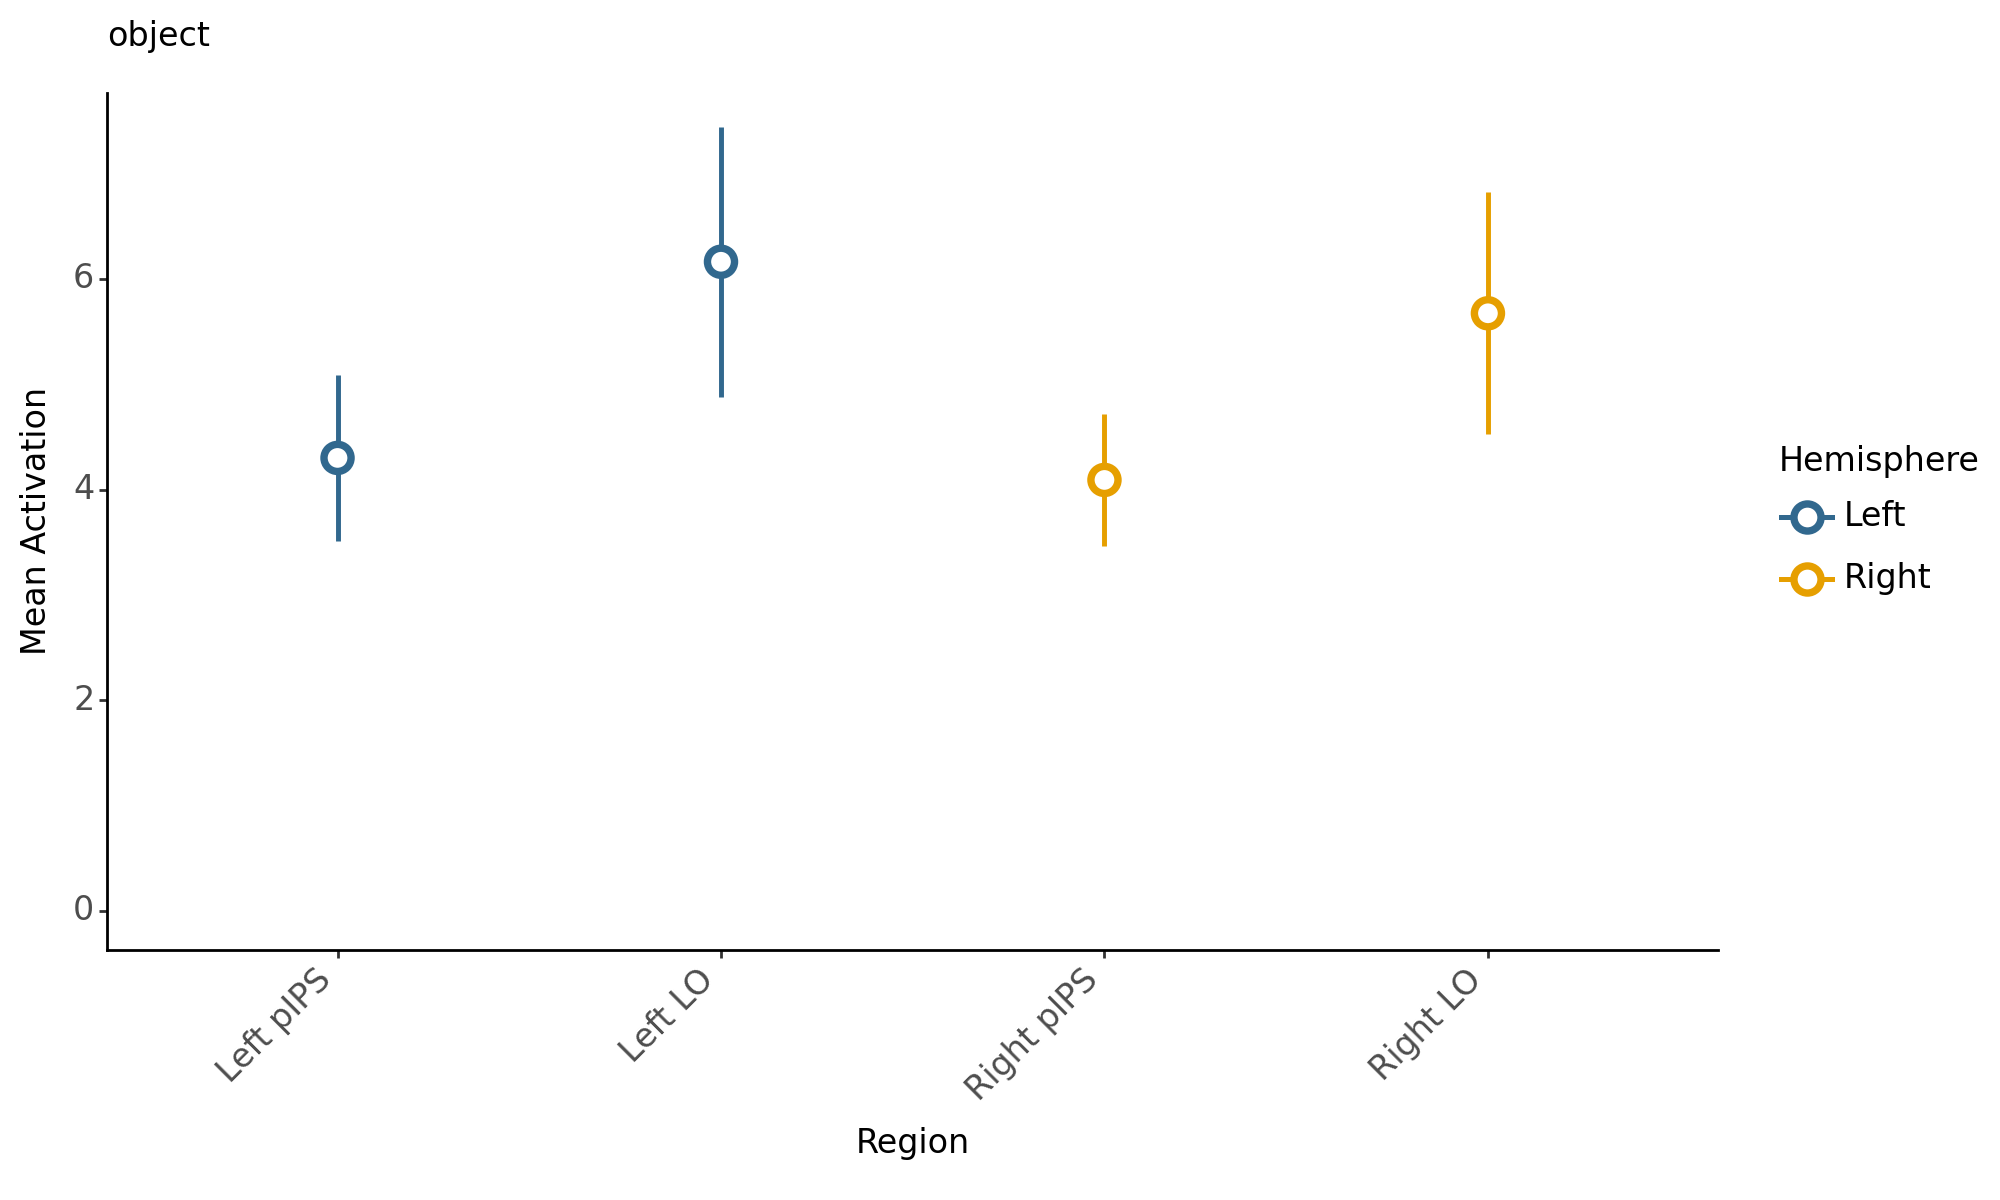

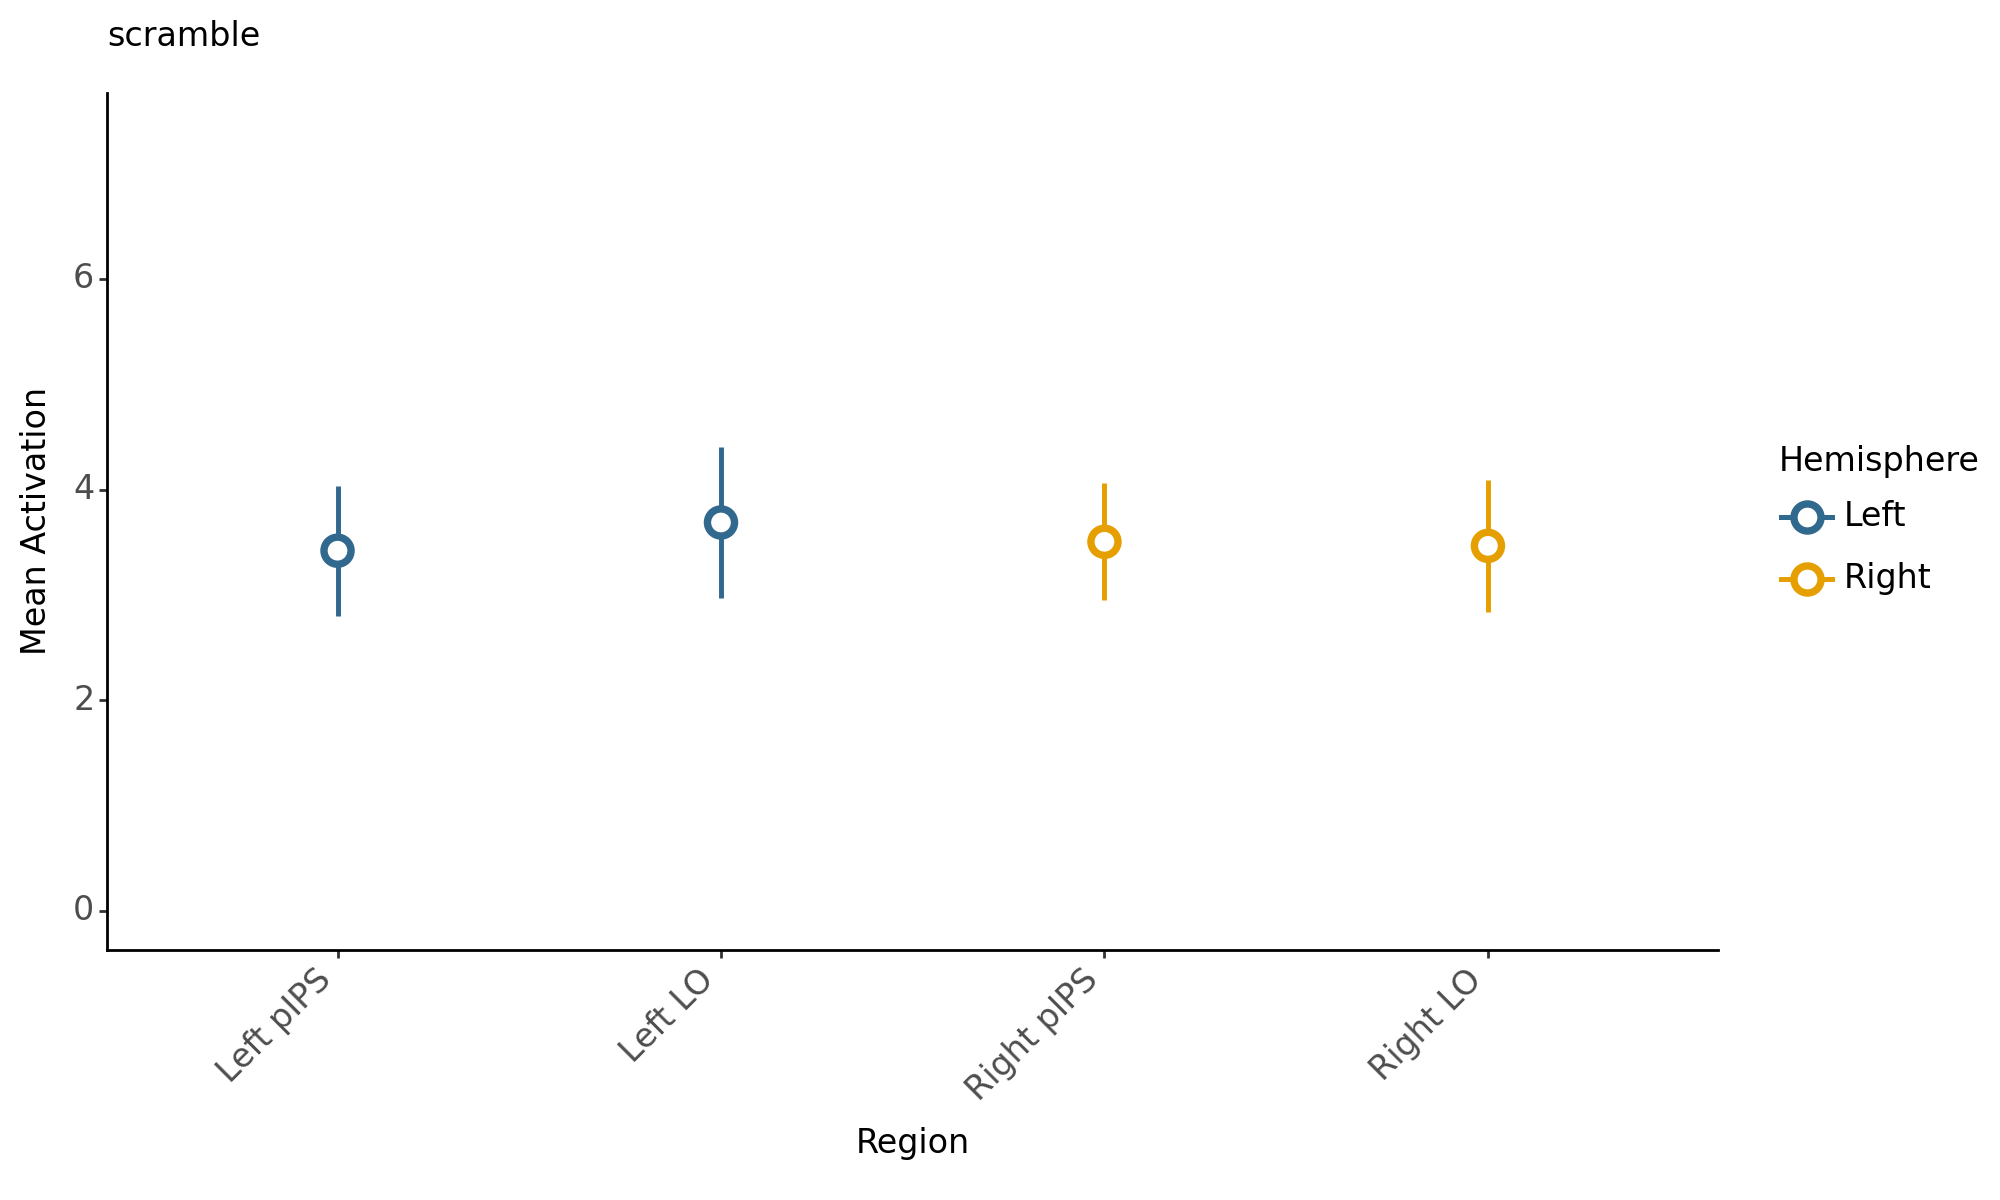

In [15]:
#roi raw activation from selectivity_summary file
import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, labs,
                      scale_color_manual, scale_shape_manual, theme, element_text, element_line, element_blank,
                      coord_cartesian, scale_x_discrete, guides, guide_legend)

# Read the CSV data
data = pd.read_csv("results/selectivity/selectivity_summary.csv")

# Filter data for controls and relevant ROIs
filtered_data = data[(data['group'] == 'control') & 
                     (data['roi'].isin(['LO', 'pIPS'])) & 
                     (data['hemi'].isin(['left', 'right']))]

# Calculate mean activation and standard deviation for each combination
summary_df = filtered_data.groupby(['hemi', 'roi', 'cond'])['mean_act'].agg(['mean', 'std', 'count']).reset_index()
summary_df['sem'] = summary_df['std'] / np.sqrt(summary_df['count'])

# Rename columns for clarity
summary_df.columns = ['Hemisphere', 'ROI', 'Condition', 'Mean', 'Std', 'Count', 'SE']

# Create more readable labels
summary_df['ROI'] = summary_df['ROI'].map({'LO': 'LO', 'pIPS': 'pIPS'})
summary_df['Hemisphere'] = summary_df['Hemisphere'].map({'left': 'Left', 'right': 'Right'})
summary_df['Region'] = summary_df['Hemisphere'] + ' ' + summary_df['ROI']

# Create a custom order for the x-axis
summary_df['Region_order'] = pd.Categorical(summary_df['Region'], 
                                            categories=['Left pIPS', 'Left LO', 'Right pIPS', 'Right LO'],
                                            ordered=True)

# Print summary statistics
print(summary_df)

# Function to create plot for a specific condition
def create_plot(data, condition):
    plot = (ggplot(data[data['Condition'] == condition],
                   aes(x='Region_order', y='Mean', color='Hemisphere'))
            + geom_linerange(aes(ymin='Mean-Std', ymax='Mean+Std'), size=1)
            + geom_point(size=4, fill='white', stroke=1.5)
            + theme_classic()
            + labs(title=f'{condition}',
                   x='Region', y='Mean Activation')
            + scale_color_manual(values={'Left': '#31688E', 'Right': '#E69F00'})
            + scale_shape_manual(values={'LO': 'o', 'pIPS': 'o'})
            + theme(text=element_text(size=12),
                    axis_text_x=element_text(angle=45, hjust=1),
                    axis_line=element_line(colour="black"),
                    panel_border=element_blank(),
                    legend_position="right",
                    legend_box_margin=0,
                    figure_size=(10, 6))
            + coord_cartesian(ylim=(0, data['Mean'].max() * 1.2))
            + scale_x_discrete(limits=['Left pIPS', 'Left LO', 'Right pIPS', 'Right LO'])
            + guides(color=guide_legend(title="Hemisphere"),
                     shape=guide_legend(title="ROI")))
    return plot

# Create and print plots
object_plot = create_plot(summary_df, 'object')
scramble_plot = create_plot(summary_df, 'scramble')

print(object_plot)
print(scramble_plot)


# Save the plots
#object_plot.save("activation_plot_object.png", dpi=300, width=8, height=6)
#scramble_plot.save("activation_plot_scramble.png", dpi=300, width=8, height=6)

/tmp/ipykernel_10495/3035121137.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10495/3035121137.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_10495/3035121137.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


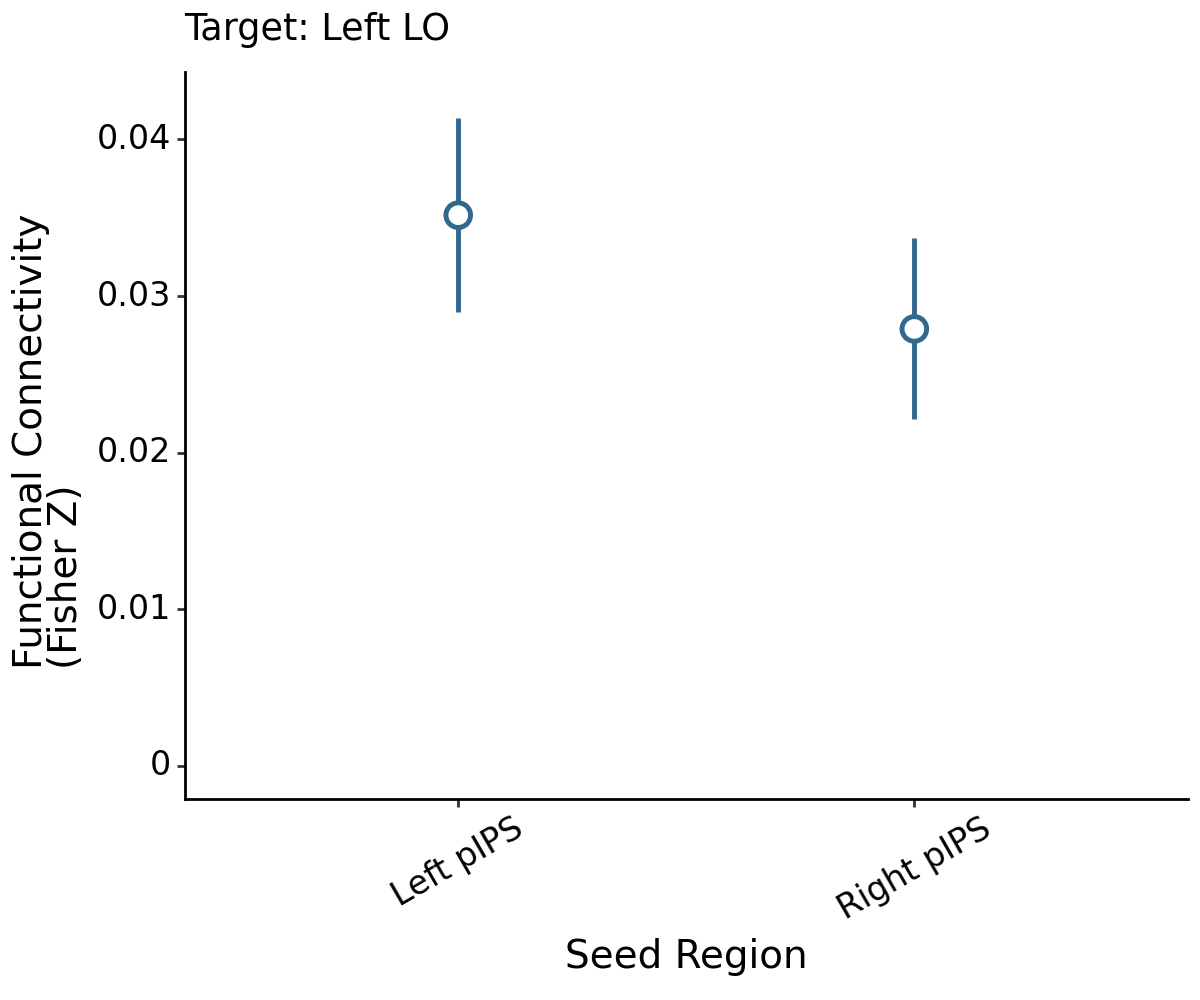

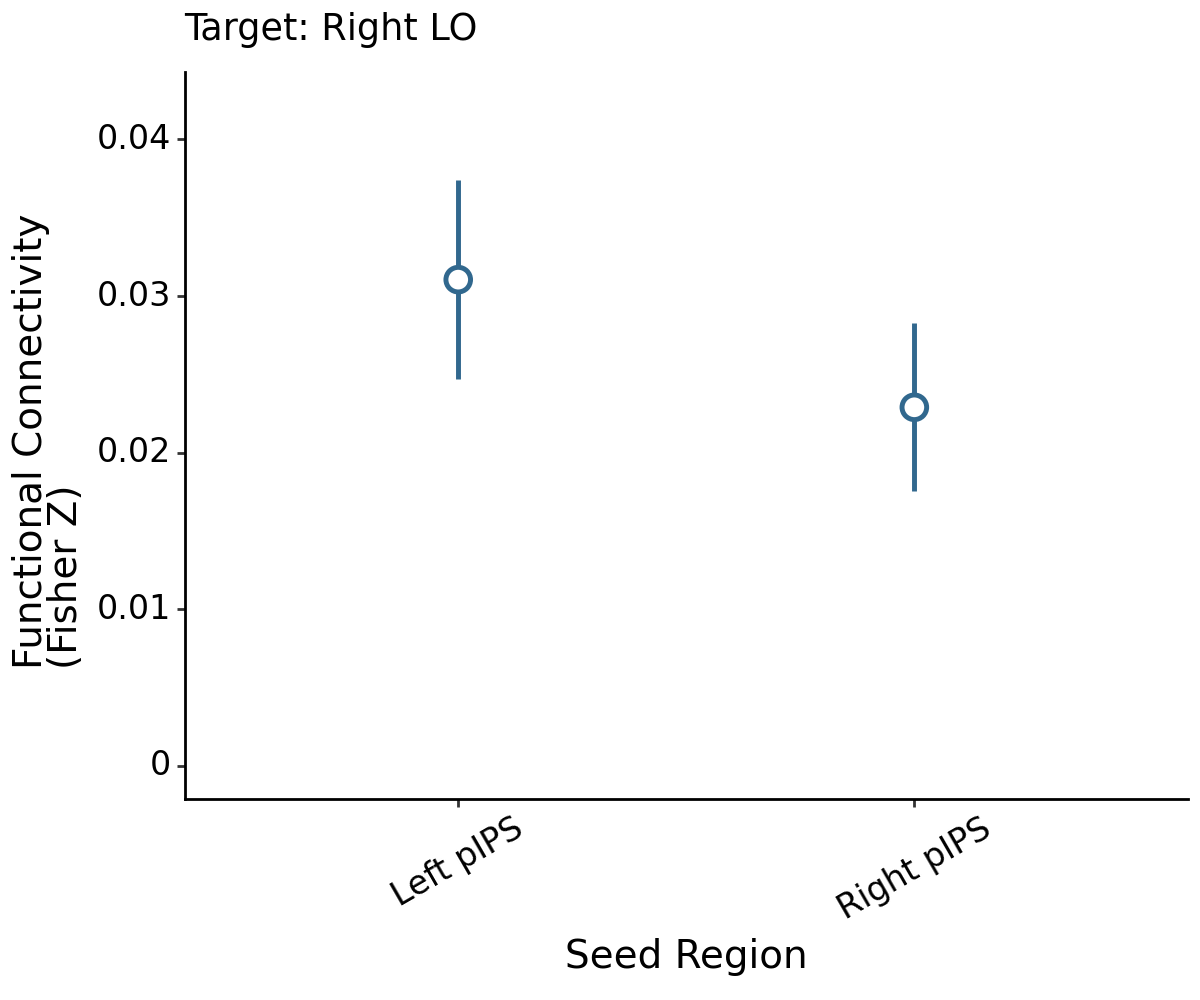

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: left_lo_ppi_plot.png
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 5 in image.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: right_lo_ppi_plot.png


In [10]:
#corrected to seed to target see - matchvlad_seed_target_activations.csv
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, scale_color_manual, theme, element_text, element_line, element_blank, facet_wrap, ggtitle

# Define variables
analysis = 'ppi'#'fc'
#analysis = 'fc'
results_dir = "results"  # Update this to your actual results directory

# Read the data
df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")

# Filter for the 'loc' task and 'ppi' analysis
df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'ppi')]
#df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'fc')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Add LOC column for seeds
summary_df['LOC'] = 'posterior'  # All seeds are pIPS, which is posterior

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

# Function to create plot for a specific target
def create_plot(data, target):
    plot = (ggplot(data[data['Target'] == target], aes(x='Seed', y='FC', color='LOC'))
            + geom_linerange(aes(ymax='FC + SE', ymin='FC - SE'), size=1)
            + geom_point(shape='o', size=4, fill='white', stroke=1)
            + ylim(0, data['FC'].max() * 1.2)  # Adjust ylim based on data
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity \n(Fisher Z)')
            + scale_color_manual(values=['#31688E'])
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(6, 5)
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
left_lo_plot = create_plot(summary_df, 'Left LO')
right_lo_plot = create_plot(summary_df, 'Right LO')

print(left_lo_plot)
print(right_lo_plot)

# Optionally, save the plots
left_lo_plot.save("left_lo_ppi_plot.png", dpi=300)
right_lo_plot.save("right_lo_ppi_plot.png", dpi=300)

In [2]:
##adapting plot of gca for raw and ppi data - non-function
import numpy as np
from plotnine import (ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, 
                      xlab, ylab, scale_color_manual, scale_shape_manual, theme, 
                      element_text, element_line, element_blank, facet_wrap, 
                      ggtitle, position_dodge2, labs)

# Define variables
analysis = 'ppi'
results_dir = "results"  # Update this to your actual results directory

# Read the data
df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")

# Filter for the 'loc' task and 'ppi' analysis
df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == analysis)]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].aes(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Add LOC column for seeds
summary_df['LOC'] = 'posterior'  # All seeds are pIPS, which is posterior

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

# Add a condition column (in this case, we only have one condition)
summary_df['condition'] = 'Object'

# Create the plot
plot = (ggplot(summary_df, aes(x='Seed', y='FC', color='condition', shape='Target'))
        + geom_linerange(aes(ymin='FC - SE', ymax='FC + SE'), 
                         size=1, position=position_dodge2(width=0.5))
        + geom_point(size=4, fill='white', stroke=1, 
                     position=position_dodge2(width=0.5))
        + ylim(0, summary_df['FC'].max() * 1.2)
        + scale_color_manual(values=['#31688E'])
        + scale_shape_manual(values=['o', 's'])
        + theme_classic()
        + labs(color='Condition', shape='Target Region')
        + xlab('Seed Region')
        + ylab('Functional Connectivity \n(Fisher Z)')
        + theme(
            text=element_text(color='black'),
            axis_text_x=element_text(angle=30, size=12),
            axis_text_y=element_text(size=12),
            axis_title=element_text(size=14),
            axis_line=element_line(),
            panel_border=element_blank(),
            legend_position="right",
            legend_box="vertical",
            legend_title=element_text(size=12),
            legend_text=element_text(size=10),
            figure_size=(10, 6)
        )
        + facet_wrap('~ condition'))

# Save the plot
plot.save(f'{results_dir}/ppi_combined_plot.png', width=10, height=6, dpi=300)

print(f"\nCombined PPI plot has been saved to {results_dir}/ppi_combined_plot.png")

In [ ]:
#edits

import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, 
                      xlab, ylab, scale_color_manual, scale_shape_manual, theme, 
                      element_text, element_line, element_blank, facet_wrap, 
                      ggtitle, position_dodge2, labs)

# Define variables
analysis = 'ppi'
results_dir = "results"  # Update this to your actual results directory

# Read the data
df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")

# Filter for the 'loc' task and 'ppi' analysis
df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == analysis)]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].aes(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Add LOC column for seeds
summary_df['LOC'] = 'posterior'  # All seeds are pIPS, which is posterior

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

# Add a condition column (in this case, we only have one condition)
summary_df['condition'] = 'Object'

# Create the plot
plot = (ggplot(summary_df, aes(x='Seed', y='FC', color='condition', shape='Target'))
        + geom_linerange(aes(ymin='FC - SE', ymax='FC + SE'), 
                         size=1, position=position_dodge2(width=0.5))
        + geom_point(size=4, fill='white', stroke=1, 
                     position=position_dodge2(width=0.5))
        + ylim(0, summary_df['FC'].max() * 1.2)
        + scale_color_manual(values=['#31688E'])
        + scale_shape_manual(values=['o', 's'])
        + theme_classic()
        + labs(color='Condition', shape='Target Region')
        + xlab('Seed Region')
        + ylab('Functional Connectivity \n(Fisher Z)')
        + theme(
            text=element_text(color='black'),
            axis_text_x=element_text(angle=30, size=12),
            axis_text_y=element_text(size=12),
            axis_title=element_text(size=14),
            axis_line=element_line(),
            panel_border=element_blank(),
            legend_position="right",
            legend_box="vertical",
            legend_title=element_text(size=12),
            legend_text=element_text(size=10),
            figure_size=(10, 6)
        )
        + facet_wrap('~ condition'))

# Save the plot
plot.save(f'{results_dir}/ppi_combined_plot.png', width=10, height=6, dpi=300)

print(f"\nCombined PPI plot has been saved to {results_dir}/ppi_combined_plot.png")